In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

In [99]:
import sagemaker

sess = sagemaker.Session()
bucket = "yudong-data"
prefix = "sagemaker/xgboost-churn"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [50]:
role

'arn:aws:iam::806174985048:role/service-role/AmazonSageMaker-ExecutionRole-20201218T151409'

In [51]:
!aws s3 cp s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt ./

download: s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt to ./churn.txt


In [52]:
churn = pd.read_csv("./churn.txt")
pd.set_option("display.max_columns", 500)
churn.head(5)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.


In [53]:
churn = churn.drop(["Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)

In [54]:
model_data = pd.get_dummies(churn)
model_data = pd.concat(
    [model_data["Churn?_True."], model_data.drop(["Churn?_False.", "Churn?_True."], axis=1)], axis=1
)

In [55]:
model_data

,Churn?_True.,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Phone_100-2030,Phone_100-2118,Phone_100-3505,Phone_100-5224,Phone_101-3371,Phone_101-4979,Phone_101-5235,Phone_101-5898,Phone_101-8787,Phone_102-3789,Phone_102-7565,Phone_102-8915,Phone_102-9284,Phone_102-9504,Phone_103-2296,Phone_103-5500,Phone_103-7280,Phone_103-7376,Phone_103-7518,Phone_103-9217,Phone_104-3389,Phone_104-7394,Phone_104-7518,Phone_104-8730,Phone_104-9169,Phone_105-2064,Phone_105-2069,Phone_105-5163,Phone_105-6646,Phone_105-8247,Phone_106-1233,Phone_106-1372,Phone_106-3732,Phone_106-3735,Phone_106-5962,Phone_106-7184,Phone_106-7313,Phone_106-8047,Phone_106-8896,Phone_106-9434,Phone_107-1287,Phone_107-2136,Phone_107-2430,Phone_107-2754,Phone_107-3707,Phone_107-6947,Phone_107-7442,Phone_108-2288,Phone_108-4158,Phone_108-7090,Phone_108-7705,Phone_108-8043,Phone_108-8102,Phone_108-9349,Phone_109-2283,Phone_109-3830,Phone_109-4382,Phone_109-6526,Phone_109-7051,Phone_109-9839,Phone_110-1578,Phone_110-2827,Phone_110-3192,Phone_110-7162,Phone_110-8895,Phone_110-9205,Phone_111-1222,Phone_111-1304,Phone_111-2033,Phone_111-5958,Phone_111-7454,Phone_111-9270,Phone_112-3348,Phone_112-9069,Phone_112-9498,Phone_113-1209,Phone_113-5190,Phone_113-5657,Phone_113-5837,Phone_113-6375,Phone_113-7885,Phone_113-8144,Phone_113-8847,Phone_113-9208,Phone_114-1011,Phone_114-4803,Phone_114-5861,Phone_114-7652,Phone_114-7878,Phone_114-8042,Phone_115-1593,Phone_115-1864,Phone_115-3889,Phone_115-4996,Phone_115-8785,Phone_116-2364,Phone_116-5522,Phone_116-6761,Phone_116-6769,Phone_116-7637,Phone_116-9885,Phone_117-3946,Phone_117-4642,Phone_117-5524,Phone_117-6066,Phone_117-6676,Phone_117-9847,Phone_118-3074,Phone_118-7198,Phone_119-1360,Phone_119-1588,Phone_119-3158,Phone_119-4124,Phone_119-8208,Phone_119-8574,Phone_120-2210,Phone_120-3055,Phone_120-3574,Phone_120-4349,Phone_120-5534,Phone_120-9083,Phone_120-9224,Phone_121-7862,Phone_122-5145,Phone_122-5503,Phone_122-7701,Phone_122-9960,Phone_123-1936,Phone_123-3904,Phone_123-6120,Phone_123-7520,Phone_123-8993,Phone_123-9659,Phone_124-1542,Phone_124-1581,Phone_124-3128,Phone_124-3218,Phone_124-5868,Phone_124-6066,Phone_124-6703,Phone_124-8374,Phone_124-9298,Phone_125-2719,Phone_125-5816,Phone_125-6326,Phone_126-1766,Phone_126-3685,Phone_126-6301,Phone_126-6809,Phone_126-9051,Phone_127-2074,Phone_127-5185,Phone_127-7305,Phone_127-9630,Phone_127-9888,Phone_127-9955,Phone_128-2146,Phone_128-4698,Phone_128-4701,Phone_128-5385,Phone_128-5488,Phone_128-7951,Phone_128-8304,Phone_128-8530,Phone_129-2853,Phone_129-4401,Phone_129-6630,Phone_129-6743,Phone_129-7137,Phone_129-7600,Phone_129-8678,Phone_129-8799,Phone_130-1130,Phone_130-2162,Phone_130-4878,Phone_130-5987,Phone_130-7128,Phone_131-1371,Phone_131-4444,Phone_131-5673,Phone_131-6666,Phone_131-7460,Phone_132-2364,Phone_132-4467,Phone_132-5971,Phone_132-6570,...,Phone_953-6864,Phone_953-7701,Phone_953-8708,Phone_953-9135,Phone_954-3434,Phone_954-5851,Phone_954-6014,Phone_954-7082,Phone_954-7762,Phone_954-9433,Phone_954-9632,Phone_955-1313,Phone_955-1711,Phone_955-3179,Phone_955-3698,Phone_955-3740,Phone_955-4359,Phone_955-4368,Phone_955-5871,Phone_955-8065,Phone_955-8130,Phone_956-4608,Phone_956-9391,Phone_957-1492,Phone_957-3539,Phone_957-3784,Phone_957-8421,Phone_958-1977,Phone_958-4341,Phone_958-6398,Phone_958-6827,Phone_958-9107,Phone_959-1651,Phone_959-3066,Phone_959-3737,Phone_959-6134,Phone_959-7593,Phone_960-3308,Phone_960-4867,Phone_960-50

In [56]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

In [57]:
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "1")
display(container)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


'306986355934.dkr.ecr.ap-northeast-2.amazonaws.com/xgboost:1'

In [58]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix1, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix1, "validation/validation.csv")
).upload_file("validation.csv")

In [59]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

In [60]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)

In [61]:
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective="binary:logistic",
    num_round=50,
    epoch=5
)

### Experiment

### Install Python SDKs

In [62]:
import sys

In [63]:
!{sys.executable} -m pip install sagemaker-experiments==0.1.24

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


### initial training experiment

In [64]:
from IPython.display import set_matplotlib_formats

from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

set_matplotlib_formats("retina")

In [65]:
from sagemaker import analytics

In [66]:
xgboost_experiment = Experiment.create(
    experiment_name=f"xgboost-churn-{int(time.time())}",
    description="Churn prediction using xgboost",
)
print(xgboost_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f19416dab70>,experiment_name='xgboost-churn-1630000569',description='Churn prediction using xgboost',tags=None,experiment_arn='arn:aws:sagemaker:ap-northeast-2:806174985048:experiment/xgboost-churn-1630000569',response_metadata={'RequestId': 'f8023c0e-3813-4e40-b5cb-deee7e0c13ca', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'f8023c0e-3813-4e40-b5cb-deee7e0c13ca', 'content-type': 'application/x-amz-json-1.1', 'content-length': '101', 'date': 'Thu, 26 Aug 2021 17:56:09 GMT'}, 'RetryAttempts': 0})


In [67]:
xgboost_trial = xgboost_experiment.create_trial(trial_name=f'xgboost-churn-1st-{int(time.time())}')

In [68]:
%%time
xgb.fit({"train": s3_input_train, "validation": s3_input_validation}, logs=True, experiment_config={
            "ExperimentName": xgboost_experiment.experiment_name,
            "TrialName": xgboost_trial.trial_name,
            "TrialComponentDisplayName": "xgboost-churn",
        })

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: xgboost-2021-08-26-17-56-11-467


2021-08-26 17:56:11 Starting - Starting the training job...
2021-08-26 17:56:13 Starting - Launching requested ML instancesProfilerReport-1630000571: InProgress
...
2021-08-26 17:57:08 Starting - Preparing the instances for training.........
2021-08-26 17:58:42 Downloading - Downloading input data...
2021-08-26 17:59:02 Training - Downloading the training image..Arguments: train
[2021-08-26:17:59:17:INFO] Running standalone xgboost training.
[2021-08-26:17:59:17:INFO] File size need to be processed in the node: 43.8mb. Available memory size in the node: 8404.52mb
[2021-08-26:17:59:17:INFO] Determined delimiter of CSV input is ','
[17:59:17] S3DistributionType set as FullyReplicated
[17:59:18] 3500x5066 matrix with 17731000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-08-26:17:59:18:INFO] Determined delimiter of CSV input is ','
[17:59:18] S3DistributionType set as FullyReplicated
[17:59:18] 1000x5066 matrix with 5066000 entries loaded from /o

In [69]:
trial_component_analytics = analytics.ExperimentAnalytics(experiment_name=xgboost_experiment.experiment_name)

In [70]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,epoch,eta,gamma,max_depth,min_child_weight,num_round,objective,silent,subsample,validation:error - Min,validation:error - Max,validation:error - Avg,validation:error - StdDev,validation:error - Last,validation:error - Count,train:error - Min,train:error - Max,train:error - Avg,train:error - StdDev,train:error - Last,train:error - Count,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,xgboost-2021-08-26-17-56-11-467-aws-training-job,xgboost-churn,arn:aws:sagemaker:ap-northeast-2:806174985048:...,306986355934.dkr.ecr.ap-northeast-2.amazonaws....,1.0,ml.m4.xlarge,30.0,5.0,0.2,4.0,5.0,6.0,50.0,binary:logistic,0.0,0.8,0.063,0.114,0.07238,0.012185,0.064,50,0.040286,0.116857,0.059497,0.018022,0.040286,50,csv,s3://yudong-data/sagemaker/DEMO-xgboost-churn-...,csv,s3://yudong-data/sagemaker/DEMO-xgboost-churn-...,None,s3://yudong-data/sagemaker/DEMO-xgboost-churn-...,[xgboost-churn-1st-1630000570],[xgboost-churn-1630000569]


In [73]:
xgboost_trial2 = xgboost_experiment.create_trial(trial_name=f'xgboost-churn-2nd-{int(time.time())}')

In [72]:
xgb2 = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)

In [74]:
xgb2.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective="binary:logistic",
    num_round=10,
    epoch=2
)

In [75]:
%%time
xgb2.fit({"train": s3_input_train, "validation": s3_input_validation}, logs=True, experiment_config={
            "ExperimentName": xgboost_experiment.experiment_name,
            "TrialName": xgboost_trial2.trial_name,
            "TrialComponentDisplayName": "xgboost-churn2",
        })

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: xgboost-2021-08-26-18-00-24-146


2021-08-26 18:00:24 Starting - Starting the training job...
2021-08-26 18:00:26 Starting - Launching requested ML instancesProfilerReport-1630000824: InProgress
...
2021-08-26 18:01:22 Starting - Preparing the instances for training.........
2021-08-26 18:02:53 Downloading - Downloading input data...
2021-08-26 18:03:17 Training - Downloading the training image...
2021-08-26 18:03:53 Uploading - Uploading generated training model
2021-08-26 18:03:53 Completed - Training job completed
Arguments: train
[2021-08-26:18:03:39:INFO] Running standalone xgboost training.
[2021-08-26:18:03:39:INFO] File size need to be processed in the node: 43.8mb. Available memory size in the node: 8418.78mb
[2021-08-26:18:03:39:INFO] Determined delimiter of CSV input is ','
[18:03:39] S3DistributionType set as FullyReplicated
[18:03:40] 3500x5066 matrix with 17731000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-08-26:18:03:40:INFO] Determined delimiter of CSV input

In [71]:
xgb.model_data

's3://yudong-data/sagemaker/DEMO-xgboost-churn-1/output/xgboost-2021-08-26-17-56-11-467/output/model.tar.gz'

In [76]:
xgb2.model_data

's3://yudong-data/sagemaker/DEMO-xgboost-churn-1/output/xgboost-2021-08-26-18-00-24-146/output/model.tar.gz'

In [115]:
from datetime import datetime, timedelta

In [83]:
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

In [84]:
from sagemaker.amazon.amazon_estimator import get_image_uri

model_name = f"xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"xgb-churn-pred2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
image_uri = get_image_uri(boto3.Session().region_name, "xgboost", "0.90-1")
image_uri2 = get_image_uri(boto3.Session().region_name, "xgboost", "0.90-2")

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [86]:
sess.create_model(
    name=model_name, role=role, container_defs={"Image": image_uri, "ModelDataUrl": xgb.model_data}
)

sess.create_model(
    name=model_name2, role=role, container_defs={"Image": image_uri2, "ModelDataUrl": xgb2.model_data}
)

INFO:sagemaker:Creating model with name: xgb-churn-pred-2021-08-26-18-13-53
INFO:sagemaker:Creating model with name: xgb-churn-pred2-2021-08-26-18-13-53


'xgb-churn-pred2-2021-08-26-18-13-53'

In [87]:
from sagemaker.session import production_variant

variant1 = production_variant(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    initial_instance_count=1,
    variant_name="Variant1",
    initial_weight=1,
)
variant2 = production_variant(
    model_name=model_name2,
    instance_type="ml.m5.xlarge",
    initial_instance_count=1,
    variant_name="Variant2",
    initial_weight=1,
)

(variant1, variant2)

({'ModelName': 'xgb-churn-pred-2021-08-26-18-13-53',
  'InstanceType': 'ml.m5.xlarge',
  'InitialInstanceCount': 1,
  'VariantName': 'Variant1',
  'InitialVariantWeight': 1},
 {'ModelName': 'xgb-churn-pred2-2021-08-26-18-13-53',
  'InstanceType': 'ml.m5.xlarge',
  'InitialInstanceCount': 1,
  'VariantName': 'Variant2',
  'InitialVariantWeight': 1})

In [88]:
%%time
endpoint_name = f"xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"EndpointName={endpoint_name}")

sess.endpoint_from_production_variants(
    name=endpoint_name, production_variants=[variant1, variant2]
)

INFO:sagemaker:Creating endpoint with name xgb-churn-pred-2021-08-26-18-15-48


EndpointName=xgb-churn-pred-2021-08-26-18-15-48
-------------!

'xgb-churn-pred-2021-08-26-18-15-48'

## Scenario 2: Load models from local

In [97]:
from sagemaker.s3 import S3Downloader, S3Uploader

In [100]:
model_url = S3Uploader.upload(
    local_path="model/xgb-churn-prediction-model.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url2 = S3Uploader.upload(
    local_path="model/xgb-churn-prediction-model2.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url, model_url2

('s3://yudong-data/sagemaker/xgboost-churn/xgb-churn-prediction-model.tar.gz',
 's3://yudong-data/sagemaker/xgboost-churn/xgb-churn-prediction-model2.tar.gz')

In [104]:
local_model_name = f"local-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
local_model_name2 = f"local-xgb-churn-pred2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
image_uri = get_image_uri(boto3.Session().region_name, "xgboost", "0.90-1")
image_uri2 = get_image_uri(boto3.Session().region_name, "xgboost", "0.90-2")

sess.create_model(
    name=local_model_name, role=role, container_defs={"Image": image_uri, "ModelDataUrl": model_url}
)

sess.create_model(
    name=local_model_name2, role=role, container_defs={"Image": image_uri2, "ModelDataUrl": model_url2}
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
INFO:sagemaker:Creating model with name: local-xgb-churn-pred-2021-08-26-18-44-28
INFO:sagemaker:Creating model with name: local-xgb-churn-pred2-2021-08-26-18-44-28


'local-xgb-churn-pred2-2021-08-26-18-44-28'

In [105]:
variant3 = production_variant(
    model_name=local_model_name,
    instance_type="ml.m5.xlarge",
    initial_instance_count=1,
    variant_name="Variant1",
    initial_weight=1,
)
variant4 = production_variant(
    model_name=local_model_name2,
    instance_type="ml.m5.xlarge",
    initial_instance_count=1,
    variant_name="Variant2",
    initial_weight=1,
)

(variant3, variant4)

({'ModelName': 'local-xgb-churn-pred-2021-08-26-18-44-28',
  'InstanceType': 'ml.m5.xlarge',
  'InitialInstanceCount': 1,
  'VariantName': 'Variant1',
  'InitialVariantWeight': 1},
 {'ModelName': 'local-xgb-churn-pred2-2021-08-26-18-44-28',
  'InstanceType': 'ml.m5.xlarge',
  'InitialInstanceCount': 1,
  'VariantName': 'Variant2',
  'InitialVariantWeight': 1})

In [108]:
%%time
endpoint_name = f"local-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"EndpointName={endpoint_name}")

sess.endpoint_from_production_variants(
    name=endpoint_name, production_variants=[variant3, variant4]
)

INFO:sagemaker:Creating endpoint with name local-xgb-churn-pred-2021-08-26-18-52-12


EndpointName=local-xgb-churn-pred-2021-08-26-18-52-12
-------------!CPU times: user 164 ms, sys: 6.52 ms, total: 171 ms
Wall time: 6min 31s


In [109]:
# get a subset of test data for a quick test
!tail -120 test_data/test-dataset-input-cols.csv > test_data/test_sample_tail_input_cols.csv
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        sm_runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType="text/csv", Body=payload)
        time.sleep(0.5)

print("Done!")

Sending test traffic to the endpoint local-xgb-churn-pred-2021-08-26-18-52-12. 
Please wait...
........................................................................................................................Done!


### invoke per variant

In [111]:
import pandas as pd

cw = boto3.Session().client("cloudwatch")


def get_invocation_metrics_for_endpoint_variant(endpoint_name, variant_name, start_time, end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
    )
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop("Unit", axis=1)
        .rename(columns={"Sum": variant_name})
    )


def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant3["VariantName"], start_time, end_time
    )
    metrics_variant2 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant4["VariantName"], start_time, end_time
    )
    metrics_variants = metrics_variant1.join(metrics_variant2, how="outer")
    metrics_variants.plot()
    return metrics_variants

Waiting a minute for initial metric creation...


,Variant1,Variant2
Timestamp,,
2021-08-26 18:57:00+00:00,0.0,NaN
2021-08-26 18:58:00+00:00,0.0,0.0
2021-08-26 18:59:00+00:00,43.0,60.0
2021-08-26 19:00:00+00:00,10.0,7.0
2021-08-26 19:01:00+00:00,0.0,0.0
2021-08-26 19:02:00+00:00,0.0,0.0
2021-08-26 19:03:00+00:00,0.0,0.0
2021-08-26 19:04:00+00:00,0.0,0.0


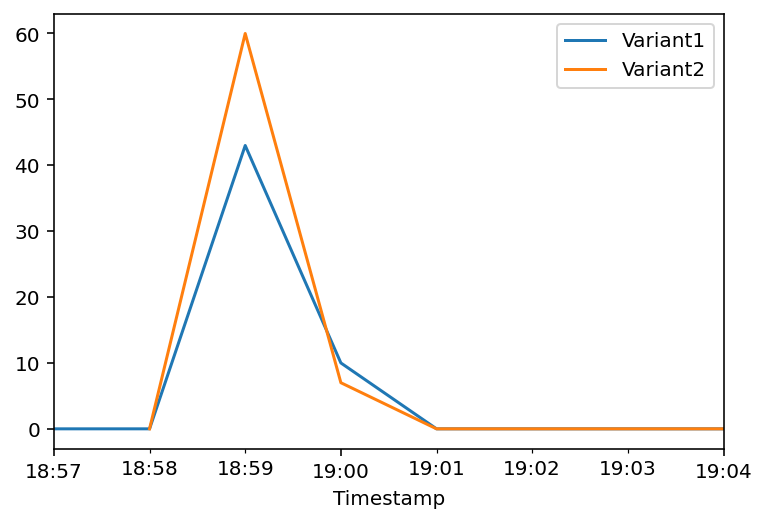

In [117]:
print("Waiting a minute for initial metric creation...")
time.sleep(30)
plot_endpoint_metrics()

### Invoke a specific variant

Now, let’s use the new feature that was released today to invoke a specific variant. For this, we simply use the new parameter to define which specific ProductionVariant we want to invoke. Let us use this to invoke Variant1 for all requests.

In [119]:
import numpy as np

predictions = ""

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            TargetVariant=variant3["VariantName"],
        )
        predictions = ",".join([predictions, response["Body"].read().decode("utf-8")])
        time.sleep(0.5)

# Convert our predictions to a numpy array
pred_np = np.fromstring(predictions[1:], sep=",")

# Convert the prediction probabilities to binary predictions of either 1 or 0
threshold = 0.5
preds = np.where(pred_np > threshold, 1, 0)
print("Done!")

Sending test traffic to the endpoint local-xgb-churn-pred-2021-08-26-18-52-12. 
Please wait...
........................................................................................................................Done!


,Variant1,Variant2
Timestamp,,
2021-08-26 18:57:00+00:00,0.0,NaN
2021-08-26 18:58:00+00:00,0.0,0.0
2021-08-26 18:59:00+00:00,43.0,60.0
2021-08-26 19:00:00+00:00,10.0,7.0
2021-08-26 19:01:00+00:00,0.0,0.0
2021-08-26 19:02:00+00:00,0.0,0.0
2021-08-26 19:03:00+00:00,0.0,0.0
2021-08-26 19:04:00+00:00,0.0,0.0
2021-08-26 19:05:00+00:00,0.0,0.0


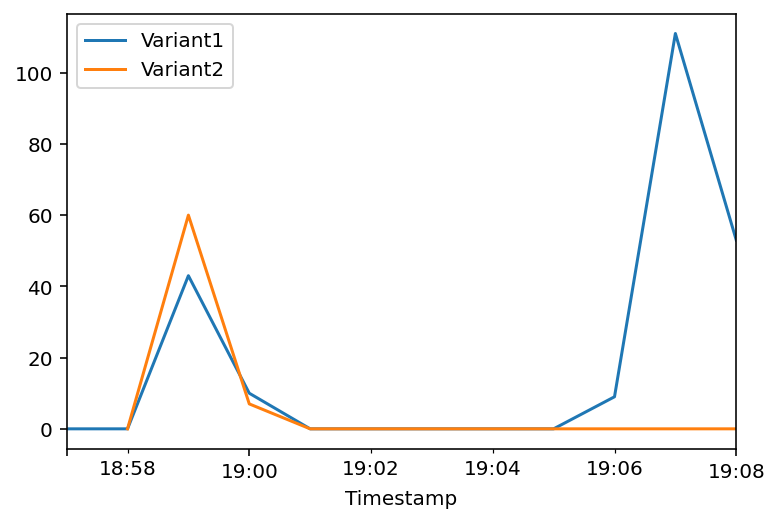

In [120]:
time.sleep(20)  # let metrics catch up
plot_endpoint_metrics()

## Evaluate variant performance

### Evaluating Variant 1

Using the new targeting feature, let us evaluate the accuracy, precision, recall, F1 score, and ROC/AUC for Variant1:

Accuracy: 0.9583333333333334
Precision: 0.9411764705882353
Recall: 0.8
F1 Score: 0.8648648648648648
AUC is 0.895


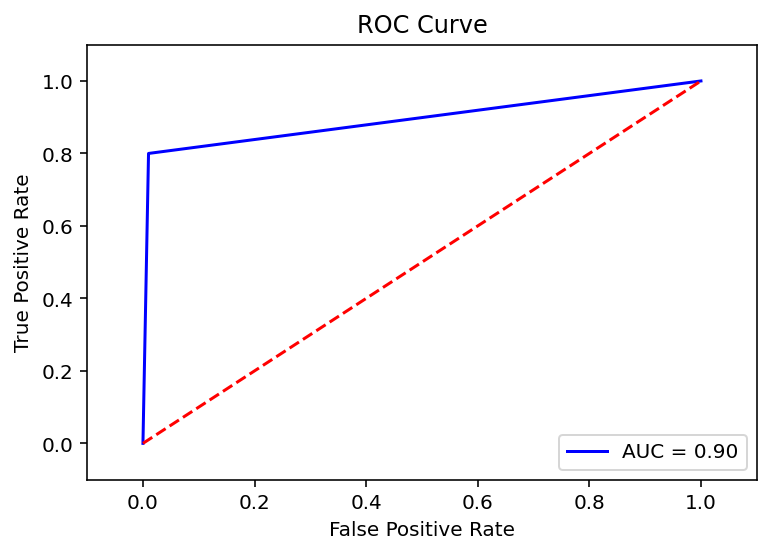

In [121]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# Let's get the labels of our test set; we will use these to evaluate our predictions
!tail -121 test_data/test-dataset.csv > test_data/test_dataset_sample_tail.csv
df_with_labels = pd.read_csv("test_data/test_dataset_sample_tail.csv")
test_labels = df_with_labels.iloc[:, 0]
labels = test_labels.to_numpy()

# Calculate accuracy
accuracy = sum(preds == labels) / len(labels)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = sum(preds[preds == 1] == labels[preds == 1]) / len(preds[preds == 1])
print(f"Precision: {precision}")

# Calculate recall
recall = sum(preds[preds == 1] == labels[preds == 1]) / len(labels[labels == 1])
print(f"Recall: {recall}")

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score}")

# Calculate AUC
auc = round(roc_auc_score(labels, preds), 4)
print("AUC is " + repr(auc))

fpr, tpr, _ = metrics.roc_curve(labels, preds)

plt.title("ROC Curve")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [122]:
predictions2 = ""
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            TargetVariant=variant4["VariantName"],
        )
        predictions2 = ",".join([predictions2, response["Body"].read().decode("utf-8")])
        time.sleep(0.5)

# Convert to numpy array
pred_np2 = np.fromstring(predictions2[1:], sep=",")

# Convert to binary predictions
thresh = 0.5
preds2 = np.where(pred_np2 > threshold, 1, 0)

print("Done!")

Sending test traffic to the endpoint local-xgb-churn-pred-2021-08-26-18-52-12. 
Please wait...
........................................................................................................................Done!


,Variant1,Variant2
Timestamp,,
2021-08-26 18:57:00+00:00,0.0,NaN
2021-08-26 18:58:00+00:00,0.0,0.0
2021-08-26 18:59:00+00:00,43.0,60.0
2021-08-26 19:00:00+00:00,10.0,7.0
2021-08-26 19:01:00+00:00,0.0,0.0
2021-08-26 19:02:00+00:00,0.0,0.0
2021-08-26 19:03:00+00:00,0.0,0.0
2021-08-26 19:04:00+00:00,0.0,0.0
2021-08-26 19:05:00+00:00,0.0,0.0


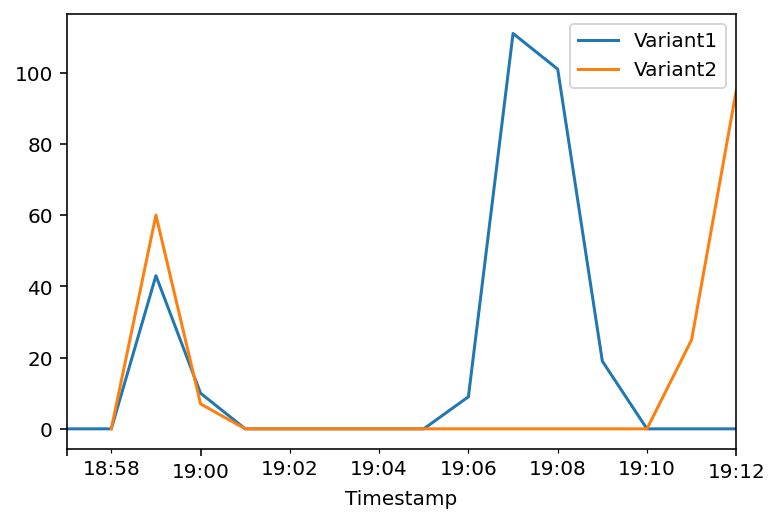

In [123]:
time.sleep(60)  # give metrics time to catch up
plot_endpoint_metrics()

Accuracy: 0.9583333333333334
Precision: 0.8947368421052632
Recall: 0.85
F1 Score: 0.8717948717948718
AUC is 0.915


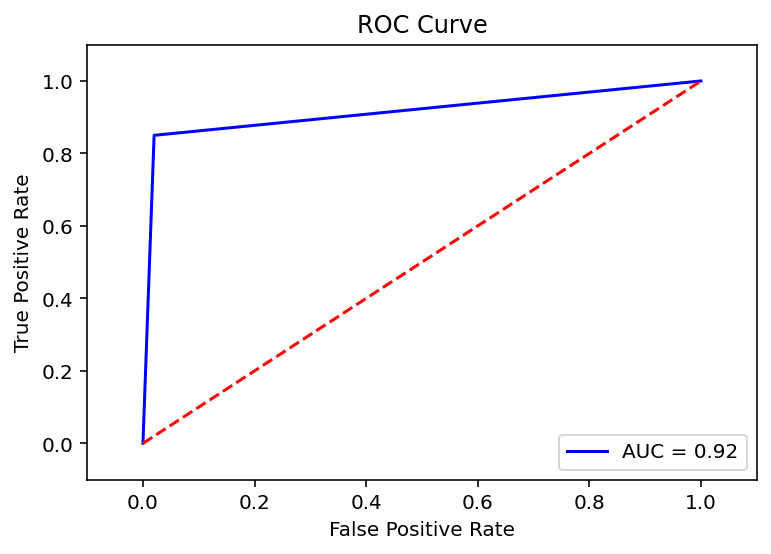

In [124]:
# Calculate accuracy
accuracy2 = sum(preds2 == labels) / len(labels)
print(f"Accuracy: {accuracy2}")

# Calculate precision
precision2 = sum(preds2[preds2 == 1] == labels[preds2 == 1]) / len(preds2[preds2 == 1])
print(f"Precision: {precision2}")

# Calculate recall
recall2 = sum(preds2[preds2 == 1] == labels[preds2 == 1]) / len(labels[labels == 1])
print(f"Recall: {recall2}")

# Calculate F1 score
f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)
print(f"F1 Score: {f1_score2}")

auc2 = round(roc_auc_score(labels, preds2), 4)
print("AUC is " + repr(auc2))

fpr2, tpr2, _ = metrics.roc_curve(labels, preds2)

plt.title("ROC Curve")
plt.plot(fpr2, tpr2, "b", label="AUC = %0.2f" % auc2)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## Dialing up our chosen variant in production


In [128]:
endpoint_name

'local-xgb-churn-pred-2021-08-26-18-52-12'

In [127]:
{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

{'Variant1': 1.0, 'Variant2': 1.0}

In [129]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {"DesiredWeight": 25, "VariantName": variant1["VariantName"]},
        {"DesiredWeight": 75, "VariantName": variant2["VariantName"]},
    ],
)

{'EndpointArn': 'arn:aws:sagemaker:ap-northeast-2:806174985048:endpoint/local-xgb-churn-pred-2021-08-26-18-52-12',
 'ResponseMetadata': {'RequestId': '45d186d0-6599-4c2e-a9a6-0426fbce2e83',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '45d186d0-6599-4c2e-a9a6-0426fbce2e83',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '113',
   'date': 'Thu, 26 Aug 2021 19:16:13 GMT'},
  'RetryAttempts': 0}}

In [130]:
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
.............................................Done


{'Variant1': 25.0, 'Variant2': 75.0}

In [132]:
def invoke_endpoint_for_two_minutes():
    with open("test_data/test-dataset-input-cols.csv", "r") as f:
        for row in f:
            print(".", end="", flush=True)
            payload = row.rstrip("\n")
            response = sm_runtime.invoke_endpoint(
                EndpointName=endpoint_name, ContentType="text/csv", Body=payload
            )
            response["Body"].read()
            time.sleep(1)

..............................................................................................................................................................................................................................................................................................................................................

,Variant1,Variant2
Timestamp,,
2021-08-26 19:27:00+00:00,6.0,20.0
2021-08-26 19:28:00+00:00,13.0,46.0
2021-08-26 19:29:00+00:00,17.0,42.0
2021-08-26 19:30:00+00:00,18.0,42.0
2021-08-26 19:31:00+00:00,15.0,44.0
2021-08-26 19:32:00+00:00,13.0,39.0


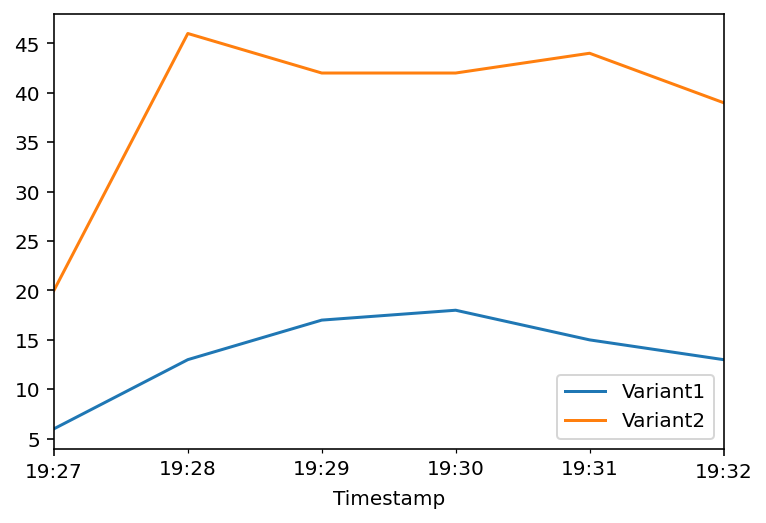

In [134]:
invocation_start_time = datetime.now()
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

In [135]:
variant1

{'ModelName': 'xgb-churn-pred-2021-08-26-18-13-53',
 'InstanceType': 'ml.m5.xlarge',
 'InitialInstanceCount': 1,
 'VariantName': 'Variant1',
 'InitialVariantWeight': 1}

In [136]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {"DesiredWeight": 0, "VariantName": variant1["VariantName"]},
        {"DesiredWeight": 1, "VariantName": variant2["VariantName"]},
    ],
)
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
...........................................................Done


{'Variant1': 0.0, 'Variant2': 1.0}

In [ ]:
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

.......................................................................................................................